In [1]:
from matplotlib import pyplot as plt
import numpy as np
import re

plt.style.use('ggplot')

In [2]:
fileName = "new.csv"
numHeaderLines = 4
delimiter = ","
yDataNames = ["time", "RKneeOut_x", "RKneeOut_y","RKneeOut_z",
              "RKneeIn_x","RKneeIn_y","RKneeIn_z",
              "RThigh_x","RThigh_y", "RThigh_z", 
              "RAsis_x", "RAsis_y", "RAsis_z",
              "RPsi_x", "RPsi_y", "RPsi_z",
              "LAsis_x", "LAsis_y", "LAsis_z",
              "LPsi_x", "LPsi_y", "LPsi_z"]

regrexHeader = r'\w+'
Data = np.genfromtxt(fileName, delimiter=delimiter, skip_header=numHeaderLines+1)

with open(fileName) as infile:
    content = infile.readlines()
    row = content[numHeaderLines]
headers = row.split(delimiter)

dataIdx = {}
for i, header in enumerate(headers):
    x = re.findall(regrexHeader, header)
    if x: 
        if (x[0] in yDataNames):
            dataIdx.update({x[0] : i})

fileData = np.zeros((Data.shape[0], len(yDataNames)))
for i,name in enumerate(yDataNames):
    fileData[:,i] = Data[:, dataIdx[name]]
    
time = fileData[:, dataIdx["time"]]

In [19]:
# Based on https://math.stackexchange.com/questions/222113/given-3-points-of-a-rigid-body-in-space-how-do-i-find-the-corresponding-orienta
# Can use the right pseudo inverse of P if using more than 3 points
def TransformationMatrix(bodyVecs, globalVecs):
    n = bodyVecs.shape[1]
    Pmean = np.mean(bodyVecs, axis=1)
    Qmean = np.mean(globalVecs, axis=1)
    
    P = bodyVecs - np.tile(Pmean.reshape(3,-1), (1,n))
    Q = globalVecs - np.tile(Qmean.reshape(3,-1), (1,n))
    
    K = np.zeros((3, 3))
    for i in range(n):
        K += np.matmul(Q[:,i].reshape(3,1), P[:,i].reshape(1,3))
    
    u,s,vh = np.linalg.svd(K)
    
    ram = np.identity(3)
    ram[2,2] = np.linalg.det(np.matmul(u,vh))
    
    R = np.matmul(u, np.matmul(ram, vh))
    d = Qmean-np.dot(R,Pmean)
    
    transformMat = np.identity(4)
    transformMat[0:3, 0:3] = R
    transformMat[0:3, 3] = d
    
    return transformMat

In [20]:
pelvisBodyVecs = np.array([[0.011497800000000001, 0.0197974, 0.128],
                   [-0.15606900000000001, 0.039409800000000002, 0.055399799999999999],
                   [0.011497800000000001, 0.0197974, -0.128],
                    [-0.15606900000000001, 0.039409800000000002, -0.055399799999999999]]).T

nRows = fileData.shape[0]
pelvisOriginGlobal = np.zeros((nRows,3))

for i in range(nRows):
    pelvisGlobalVecs = np.reshape(fileData[i,10:], (4,3)).T
    pelvis_transformMat = TransformationMatrix(pelvisBodyVecs, pelvisGlobalVecs)
    pelvisOriginGlobal[i,:] = pelvis_transformMat[0:3,3]

vin = np.concatenate((time.reshape(-1,1),pelvisOriginGlobal), axis=1)
np.savetxt("pelvisPredictedNew.csv", vin, delimiter=",")

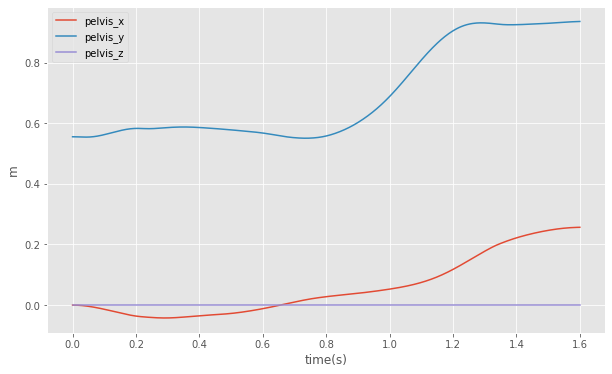

In [21]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.plot(time, pelvisOriginGlobal[:,0], label="pelvis_x")
axs.plot(time, pelvisOriginGlobal[:,1], label="pelvis_y")
axs.plot(time, pelvisOriginGlobal[:,2], label="pelvis_z")
axs.set_xlabel("time(s)")
axs.set_ylabel("m")
axs.legend()

plt.show()

In [22]:
# femur body vecs [RKneeOut, RKneeIn, RThigh]
time = fileData[:, dataIdx["time"]]
femurBodyVecs = np.array([[0.015749900000000001, -0.40403899999999998, 0.0498872],
                   [0.0046475099999999997, -0.40554099999999998, -0.048730299999999997],
                   [0.0092257799999999994, -0.121377, 0.089914999999999995]]).T

pelvisBodyVecs = np.array([[0.011497800000000001, 0.0197974, 0.128],
                   [-0.15606900000000001, 0.039409800000000002, 0.055399799999999999],
                   [0.011497800000000001, 0.0197974, -0.128]]).T

nRows = fileData.shape[0]
A = np.zeros((3*nRows, 6))
b = np.zeros((3*nRows, 1))

for i in range(nRows):
    pelvisGlobalVecs = np.reshape(fileData[i,10:-3], (3,3)).T
    pelvis_transformMat = TransformationMatrix(pelvisBodyVecs, pelvisGlobalVecs)
    
    femurGlobalVecs = np.reshape(fileData[i,1:10], (3,3)).T
    femur_transformMat = TransformationMatrix(femurBodyVecs, femurGlobalVecs)    
    
    R1 = pelvis_transformMat[0:3, 0:3]
    R2 = femur_transformMat[0:3, 0:3]
    A[3*i:3*(i+1), :] = np.concatenate((np.identity(3), -np.matmul(R1.T, R2)), axis=1);
    
    femur_pelvis_pos_global = femur_transformMat[0:3,3] - pelvis_transformMat[0:3,3]
    femur_pelvis_pos = np.matmul(R1.T, femur_pelvis_pos_global)
    b[3*i:3*(i+1), 0] = femur_pelvis_pos

vin = np.linalg.lstsq(A,b)[0]
print(vin)

[[-5.62760000e-02]
 [-7.84900000e-02]
 [ 1.52534934e-01]
 [-4.85722573e-17]
 [ 9.71445147e-17]
 [ 7.52749343e-02]]


<ipython-input-22-5fabf1dbcad9>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vin = np.linalg.lstsq(A,b)[0]
